In [1]:
import sys,os
sys.path.append('../CFEP_simulate_test')
# print(os.getcwd())

In [2]:
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

import seaborn as sns

import CFEP
import CFEP_with_sij
from Sim_test_func import *

import random
import pandas as pd
import numpy as np
import pickle

# from numpy import random
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score

random.seed(12345)


In [3]:
def com_dict2list_for_CFEP_sij(original_dict):
    # Creating a new dictionary where values are lists of keys from the original dictionary
    new_dict = {}
    for key, value in original_dict.items():
        # Append the key to the list of keys for the current value
        new_dict.setdefault(value, []).append(key)
    return list(new_dict.values())


# Function to determine if an edge is within a subgraph
def is_intra_subgraph_edge(u, v, subgraph_nodes):
   # Create the subgraph
    subgraph = G.subgraph(subgraph_nodes)

    # Check if both nodes are in the subgraph
    if u not in subgraph or v not in subgraph:
        return False

    # Check if there is an edge between node1 and node2 in the subgraph
    return subgraph.has_edge(u, v)

def get_colors(com_num):
    color_list = ['#ACC6DE','#F3CCA4','#B4D8AD',]
    com_color = []
    for index, num in enumerate(com_num):
        for _ in range(num):
            com_color.append(color_list[index])
    return com_color

def stat_table_in_de(G_p2,G_p1, com_list):
    pseudo_p_value_list=[]
    intra_edge_num=[]
    inter_edge_num=[]
    intra_change_mean=[]
    inter_change_mean=[]
    mean_diff=[]
    
    sig_com = []
    for com in com_list:
        if len(com)==1:
            continue
        iter_num=999
        intra_rates,inter_rates=real_change_rate(com,G_p2,G_p1)
        if len(intra_rates)==0:
            continue
        intra_edge_num.append((len(intra_rates)))
        inter_edge_num.append((len(inter_rates)))
        intra_change_mean.append(round(sum(intra_rates)/len(intra_rates),3))
        inter_change_mean.append(round(sum(inter_rates)/len(inter_rates),3))
        diff_mean_real=sum(intra_rates)/len(intra_rates)-sum(inter_rates)/len(inter_rates)
        mean_diff.append(diff_mean_real)
        diff_mean=shuffle_change_rate(intra_rates,inter_rates,diff_mean_real,iter_num)
        count_random_larger_than_real=0
        for diff in diff_mean:
            if diff>=diff_mean_real:
                count_random_larger_than_real+=1
        pseudo_p_value=(count_random_larger_than_real+1)/(iter_num+1)
        pseudo_p_value_list.append(pseudo_p_value)
        if pseudo_p_value<0.05 and len(com)>2:
            sig_com.append(com)

    stat_df=pd.DataFrame.from_dict({#'Flow groups':labels,
                                    'Intra-flow':intra_edge_num,
                                    # 'Inter-flow':inter_edge_num,
                                    # 'Average intra-change rate':intra_change_mean,
                                    # 'Average inter-change rate':inter_change_mean,
                                    # 'Mean diff': mean_diff,
                                    '$R_{int}^{F}$':intra_change_mean,
                                    '$R_{ext}^{F}$':inter_change_mean,
                                    # 'Mean difference':mean_diff,
                                    'Pseudo p-value':pseudo_p_value_list})

    # stat_df.set_index('Flow groups')
    # stat_df_co_in=stat_df.T
    return stat_df, sig_com

def stat_table_stable(G_p2,G_p1, com_list):
    pseudo_p_value_list=[]
    intra_edge_num=[]
    inter_edge_num=[]
    intra_change_mean=[]
    inter_change_mean=[]
    mean_diff=[]
    for com in com_list:
        if len(com)==1:
            continue
        iter_num=999
        intra_rates,inter_rates=real_change_rate(com,G_p2,G_p1)
        intra_edge_num.append(len(intra_rates))
        inter_edge_num.append(len(inter_rates))
        intra_change_mean.append(sum(intra_rates)/len(intra_rates))
        inter_change_mean.append(sum(inter_rates)/len(inter_rates))
        diff_mean_real=sum(intra_rates)/len(intra_rates)-sum(inter_rates)/len(inter_rates)
        mean_diff.append(diff_mean_real)
        diff_mean=shuffle_change_rate(intra_rates,inter_rates,diff_mean_real,iter_num)
        count_random_larger_than_real=0
        for diff in diff_mean:
            if diff<=diff_mean_real:
                count_random_larger_than_real+=1
        pseudo_p_value=(count_random_larger_than_real+1)/(iter_num+1)
        pseudo_p_value_list.append(pseudo_p_value)

    stat_df=pd.DataFrame.from_dict({#'Flow groups':labels,
                                    # 'Intra-flow':intra_edge_num,
                                    # 'Inter-flow':inter_edge_num,
    #                                 'Average intra-change rate':intra_change_mean,
    #                                 'Average inter-change rate':inter_change_mean,
                                    '$R_{int}^{F}$':intra_change_mean,
                                    '$R_{ext}^{F}$':inter_change_mean,
                                    # 'Mean difference':mean_diff,
                                    'Pseudo p-value':pseudo_p_value_list})

    # stat_df.set_index('Flow groups')
    # stat_df_po_co=stat_df.T
    return stat_df

def real_change_rate(target_community,G_p2,G_p1):
    intra_edges=list(G_p2.subgraph(target_community).edges())

    inter_edges=[]
    rest_nodes=set(range(60))-set(target_community)

    for node_in_group in target_community:
        for node_outside_group in rest_nodes:
            if G_p2.has_edge(node_in_group,node_outside_group):
                inter_edges.append((node_in_group,node_outside_group))

    intra_rates=[]
    for edge in intra_edges:
        intra_rates.append(G_p2[edge[0]][edge[1]]['weight']/G_p1[edge[0]][edge[1]]['weight'])
    inter_rates=[]
    for edge in inter_edges:
        inter_rates.append(G_p2[edge[0]][edge[1]]['weight']/G_p1[edge[0]][edge[1]]['weight'])
    
    return intra_rates,inter_rates

def shuffle_change_rate(intra_rates,inter_rates,diff_mean_real,iter_num=999):
    intra_rates_and_inter_rates=intra_rates+inter_rates
    #inter 0, intra 1
    intra_rates_label=[1 for i in intra_rates]
    inter_rates_label=[0 for i in intra_rates]
    intra_label_inter_label=intra_rates_label+inter_rates_label
    diff_mean=[]
#     diff_mean.append(diff_mean_real)
    # print(intra_label_inter_label)
    for i in range(iter_num):
        random_rate=intra_label_inter_label.copy()
        random.shuffle(random_rate)
        new_intra_rates=[]
        new_inter_rates=[]
        for index,label in enumerate(random_rate):
            if label==1:
                new_intra_rates.append(intra_rates_and_inter_rates[index])
            else:
                new_inter_rates.append(intra_rates_and_inter_rates[index])
        mean_intra=sum(new_intra_rates)/len(new_intra_rates)
        mean_inter=sum(new_inter_rates)/len(new_inter_rates)
        diff_mean.append(mean_intra-mean_inter)
    return diff_mean

# Function to check if an edge connects to a subgraph
def connects_to_subgraph(u, v, subgraphs):
    for subgraph in subgraphs:
        if (u in subgraph and v not in subgraph) or (v in subgraph and u not in subgraph):
            return True
    return False

def Precision_Recall(incre_subgraph, y_true):
    
    all_internal_edge = set()

    for subgraph in incre_subgraph:
        for u, v in G.edges():
            if is_intra_subgraph_edge(u, v, subgraph):
                edge = tuple(sorted([u, v]))
                all_internal_edge.add(edge)
                
    y_predict = []
    for edge in all_edges:
        if edge in all_internal_edge:
            y_predict.append(1)
        else:
            y_predict.append(0)
            
    precision = precision_score(y_true, y_predict)
    print(f"Precision: {precision}")

    # Calculate Recall
    recall = recall_score(y_true, y_predict)
    print(f"Recall: {recall}")
    return precision, recall

## visualization

In [4]:
def flow_boxplot_edge_ratio_one_columns(com_dict_min_best_p,
                                        G_p1,G_p2,
                                        selected_high_weights_list,
                                        inter_subgraph_weights_new,
                                        three_group_true_edge,
                                        three_group_noise_edge,
                                        b, 
                                        save_name,
                                        show_inter = True,
                                        com_is_list=True,
                                        figure_size=(5,5)):
    #G_p1/G_p2
    result_partition=0
    if com_is_list:
        result_partition=com_dict_min_best_p
    else:
        result_partition=com_dict2list(com_dict_min_best_p)
        
    intra_Flow_rate=[]
    inter_Flow_rate=[]
    intra_Flow_rate_all = []

    for node_set in result_partition:
        if len(node_set)==1:
            continue
        com=G_p1.subgraph(node_set)
        
        true_intra_f_rate_for_all = []
        true_intra_f_rate=dict()
        true_intra_f_rate['0'] = []
        true_intra_f_rate['1'] = []
        true_intra_f_rate['2'] = []
        noise_intra_f_rate=[]
        miss_ext_f_rate = []
        for edge in com.edges():
            edge_set = tuple(sorted([edge[0], edge[1]]))
            rate = G_p1[edge[0]][edge[1]]['weight']/G_p2[edge[0]][edge[1]]['weight']
            true_intra_f_rate_for_all.append(rate)
            not_in_true_edge = True
            in_org_exter = True
            for i, one_group in enumerate(three_group_true_edge):
                if edge_set in one_group:
                    
                    true_intra_f_rate[str(i)].append(rate)
                    not_in_true_edge=False
                    in_org_exter = False
                    
            if not_in_true_edge:
                for one_group in three_group_noise_edge:
                    if edge_set in one_group:
                        noise_intra_f_rate.append(rate)
                        in_org_exter = False
            if in_org_exter:
                miss_ext_f_rate.append(rate)
            
        intra_Flow_rate.append([true_intra_f_rate, noise_intra_f_rate, miss_ext_f_rate])
        intra_Flow_rate_all.append(true_intra_f_rate_for_all)
        
        inter_rate=[]
        rest_nodes=set(range(60))-set(node_set)
        for node_in_group in node_set:
            for node_outside_group in rest_nodes:
                if G_p2.has_edge(node_in_group,node_outside_group):
                    inter_rate.append(G_p1[node_in_group][node_outside_group]['weight']/G_p2[node_in_group][node_outside_group]['weight'])
        inter_Flow_rate.append(inter_rate)
        
    agg_intra_inter_list=[]
    for intra,inter in zip(intra_Flow_rate_all,inter_Flow_rate):
        agg_intra_inter_list.append([inter,intra])
        
    pos_list=[]
    for i in range(len(agg_intra_inter_list)):
        if i==0:
            pos_list.append(((i+1)*1.5,(i+1.8)*1.5))
        else:
            pos_list.append(((i+1)*1.5+2*i,(i+1.8)*1.5+2*i))
    fig = plt.figure(dpi=300,figsize=figure_size)
    gs = GridSpec(1, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0:1])
    ax = fig.add_subplot(gs[0, 1:3], sharey=ax1)
    box_labels=['inter','intra']
    for i in range(len(agg_intra_inter_list)):
        ax.boxplot(agg_intra_inter_list[i][1],
                    vert=True,  # vertical box alignment
                    patch_artist=False,  # fill with color
                    showfliers=False,
                    labels=[box_labels[1]],
                    positions=[pos_list[i][0]],
                    widths=0.8,
                    showmeans=True,meanline=True,
                    medianprops={'lw':0},
                    meanprops={'lw':1.5,'color':'red','ls':'-'})  # will be used to label x-ticks
        if show_inter:
            ax.boxplot(agg_intra_inter_list[i][0],
                        vert=True,  # vertical box alignment
                        patch_artist=False,  # fill with color
                        showfliers=False,
                        labels=[box_labels[0]],#box_labels[0],
                        positions=[pos_list[i][1]],
                        widths=0.8,
                        showmeans=True,meanline=True,
                        medianprops={'lw':0},
                        meanprops={'lw':1.5,'color':'red','ls':'-'},
                        boxprops={'linewidth': 1.5, 'color': '#c0c2c0'},  # properties for box
                        whiskerprops={'linewidth': 1.5, 'color': '#c0c2c0'},  # properties for whiskers
                        capprops={'linewidth': 1.5, 'color': '#c0c2c0'})  # will be used to label x-ticks
        
    
    
    
    dis_colors=['#ACC6DE',
                '#F3CCA4',
                '#B4D8AD', 
                '#c0c2c0']
    for i in range(len(intra_Flow_rate)):
    
        for j in range(3):
            one_group_rate = intra_Flow_rate[i][0][str(j)]
            x = list(np.random.normal(pos_list[i][0], 0.2, len(one_group_rate)))
            ax.scatter(x, one_group_rate, c=dis_colors[j], alpha=1,edgecolors='grey',linewidths=0.5)
        
        one_group_rate = intra_Flow_rate[i][1]
        x = list(np.random.normal(pos_list[i][0], 0.2, len(one_group_rate)))
        ax.scatter(x, one_group_rate, c='red', alpha=0.1, edgecolors='red',linewidths=0.1)#, facecolors='none'
        ax.scatter(x, one_group_rate, facecolors='none', alpha=1, edgecolors='red',linewidths=0.2)#, facecolors='none'
        
        one_group_rate = intra_Flow_rate[i][2]
        x = list(np.random.normal(pos_list[i][0], 0.2, len(one_group_rate)))
        ax.scatter(x, one_group_rate, c='#c0c2c0', alpha=1,edgecolors='grey',linewidths=0.5)
                 
        
        
    ax.set_xticks([])
    ax.set_xlabel('Flow groups')
    ax.spines['left'].set_visible(False)
    ax.yaxis.tick_right()
    ax1.hist([[i[0] for i in selected_high_weights_list[0]], 
              [i[0] for i in selected_high_weights_list[1]], 
              [i[0] for i in selected_high_weights_list[2]], 
              inter_subgraph_weights_new],
             bins = b, 
             color=dis_colors, 
             stacked=True, 
             label=['Subset 1', 'Subset 2', 'Subset 3', 'inter-connection'], 
             orientation='horizontal')
    
    ax1.spines['right'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_ylabel('Change rate')
    # plt.xscale('log')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    plt.subplots_adjust(wspace =0, hspace =0)
    plt.show()
    fig.savefig(save_name+'.png', dpi = 300)
    return ax
    

## Generate graph

In [5]:
# Redefining the function for subgraph weight assignment
def assign_larger_weights_to_subgraph(incre_subgraph, 
                                      high_weight_percentage, 
                                      noise_assign_seed):
    
    ini_weight = 100
    subgraph_edges_list = []
    total_num_subgraph_edge = 0
    subgraph_edges_weight = []
    selected_high_weights_list = []
    unselected_low_weight_edge_num = []
    external_subgraph_weights = []
    internal_subgraph_weights = []
    
    ground_true_edge = set()
    
    for i in range(len(incre_subgraph)):
        
        subgraph_edges = [(u, v) for u, v in G.edges() if is_intra_subgraph_edge(u, v, incre_subgraph[i])]
        print('Subgraph flow number: ', len(subgraph_edges))
        high_weight_count = int(len(subgraph_edges) * high_weight_percentage)
        unselected_low_weight_edge_num.append(len(subgraph_edges)-high_weight_count)
        # Select high weights for this subgraph
        selected_high_weights = total_weights_list[-high_weight_count:]
        selected_high_weights = [[i, 1] for i in selected_high_weights]
        
        # Remove the selected high weights from the total weights
        for weight in selected_high_weights:
            total_weights_list.remove(weight[0])
        
        
        subgraph_edges_list.append(subgraph_edges)
        selected_high_weights_list.append(selected_high_weights)
        
        total_num_subgraph_edge+=len(subgraph_edges)

    # random.seed(20)
    # selected_low_weights_list = []
    # for i in range(len(incre_subgraph)):
    #     # Select the remaining low weights for this subgraph
    #     selected_low_weights = random.sample(total_weights_list, unselected_low_weight_edge_num[i])
    #     selected_low_weights = [[i, 0] for i in selected_low_weights]
    #     selected_low_weights_list.append(selected_low_weights)
    #     # Remove the selected low weights from the total weights
    #     for weight in selected_low_weights:
    #         total_weights_list.remove(weight[0])
            
    random.seed(20)
    selected_low_weights_list = []
    for i in range(len(incre_subgraph)):
        # Select the remaining low weights for this subgraph
        selected_low_weights = []
        for _ in range(unselected_low_weight_edge_num[i]):
            low_weight = total_weights_list.pop(0)
            selected_low_weights.append(low_weight)
        selected_low_weights = [[i, 0] for i in selected_low_weights]
        selected_low_weights_list.append(selected_low_weights)

    np.random.seed(noise_assign_seed)
    three_group_true_edge = []
    three_group_noise_edge = []
    for i in range(len(incre_subgraph)):
        # Combine and shuffle the selected weights
        subgraph_weights = np.concatenate((selected_high_weights_list[i], selected_low_weights_list[i]))
        np.random.shuffle(subgraph_weights)
        internal_subgraph_weights.append(subgraph_weights)
        
        one_group_edge_true = set()
        one_group_edge_noise = set()
        
        # Assign weights to the subgraph edges
        for edge, weight in zip(subgraph_edges_list[i], subgraph_weights):
            G[edge[0]][edge[1]]['weight'] = weight[0]
            G_t1[edge[0]][edge[1]]['weight'] = ini_weight
            G_t2[edge[0]][edge[1]]['weight'] = ini_weight * weight[0]
            if weight[1]==1:
                ground_true_edge.add(tuple(sorted([edge[0], edge[1]])))
                one_group_edge_true.add(tuple(sorted([edge[0], edge[1]])))
            else:
                one_group_edge_noise.add(tuple(sorted([edge[0], edge[1]])))
                
        three_group_true_edge.append(one_group_edge_true)
        three_group_noise_edge.append(one_group_edge_noise)
    
    edges_connecting_subgraphs = set()
    for subgraph in incre_subgraph:
        for u, v in G.edges():
            if connects_to_subgraph(u, v, incre_subgraph):
                # Sort nodes to treat edge (u, v) and (v, u) as the same
                edge = tuple(sorted([u, v]))
                edges_connecting_subgraphs.add(edge)
    
    # Assign lower weights to edges connecting to subgraphs
    for edge in edges_connecting_subgraphs:
        low_weight = total_weights_list.pop(0)  # Assuming total_weights_list is sorted and low weights are at the start
        G[edge[0]][edge[1]]['weight'] = low_weight
        G_t1[edge[0]][edge[1]]['weight'] = ini_weight
        G_t2[edge[0]][edge[1]]['weight'] = ini_weight * low_weight
        external_subgraph_weights.append(low_weight)
        
    # Assign remaining weights to other edges
    for u, v in G.edges():
        if not G[u][v].get('weight'):
            weight = total_weights_list.pop(0)
            G[u][v]['weight'] = weight
            G_t1[u][v]['weight'] = ini_weight
            G_t2[u][v]['weight'] = ini_weight * weight
            external_subgraph_weights.append(weight)
            
    y_true = []
    for edge in all_edges:
        if edge in ground_true_edge:
            y_true.append(1)
        else:
            y_true.append(0)

    return selected_high_weights_list, selected_low_weights_list, external_subgraph_weights, y_true, three_group_true_edge, three_group_noise_edge


The total number of edge weight:  1425
Subgraph flow number:  158
Subgraph flow number:  151
Subgraph flow number:  149


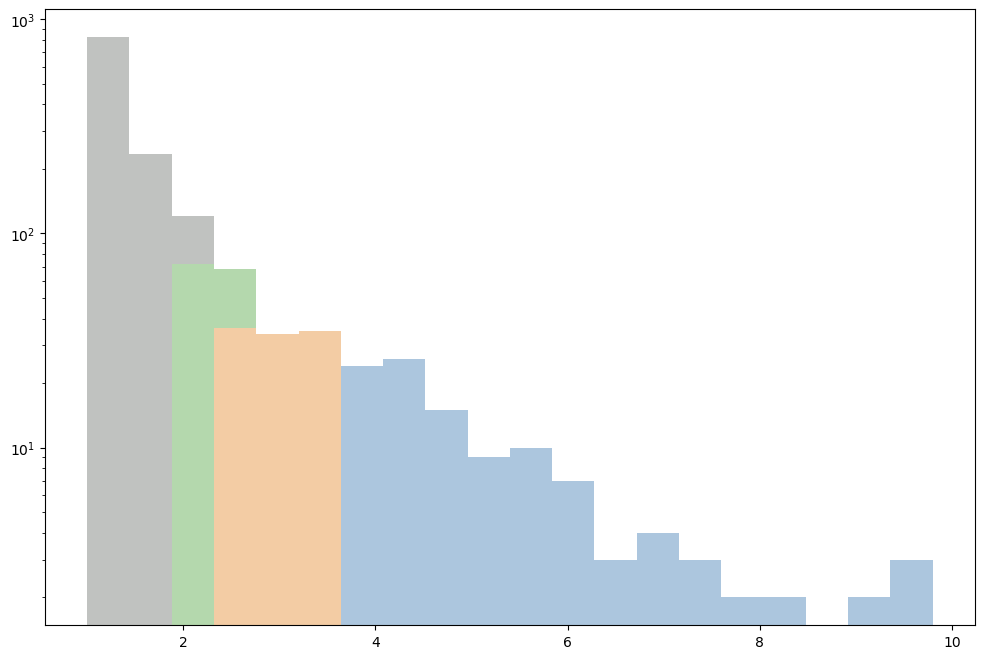

In [7]:
# Define the network parameters
incre_subgraph=[list(range(20)),list(range(20,40)), list(range(40,60))]

seed = 100
ini_weight = 100
high_weight_percentage = 0.7
max_value = 10
exp = 3

# Create the stochastic block model
G = nx.erdos_renyi_graph(60, 0.8, seed = seed)

G_t1 = G.copy()
G_t2 = G.copy()

all_edges = set()
for u, v in G.edges():
    edge = tuple(sorted([u, v]))
    all_edges.add(edge)

# Re-generating the total power-law edge weight distribution considering all edges
total_edge_count = len(G.edges())


# Calculating the probabilities following the distribution 3 * x^-3
probabilities = exp * np.power(np.arange(1, max_value, 0.1), -1*exp)
# Normalizing the probabilities so they sum up to 1
probabilities /= probabilities.sum()
np.random.seed(0)
total_weights = np.random.choice(np.arange(1, 10, 0.1), size=total_edge_count, p=probabilities)
total_weights.sort()  # Sort the weights
total_weights_list = list(total_weights)
print('The total number of edge weight: ', len(total_weights_list))
# Redefining the function for subgraph weight assignment

# Assign weights to each subgraph
selected_high_weights_list, selected_low_weights_list, external_subgraph_weights, coin_true, three_group_true_edge, three_group_noise_edge= assign_larger_weights_to_subgraph(incre_subgraph,high_weight_percentage, 0)

all_low_weight_incl_noise = np.concatenate(([i[0] for i in selected_low_weights_list[0]], 
                                            [i[0] for i in selected_low_weights_list[1]], 
                                            [i[0] for i in selected_low_weights_list[2]], 
                                            external_subgraph_weights))
# Visualization of the adjusted weight distributions
plt.figure(figsize=(12, 8))


dis_colors=['#ACC6DE',
            '#F3CCA4',
            '#B4D8AD', 
            '#c0c2c0', 
            '#c0c2c0', 
            '#c0c2c0',
            '#c0c2c0'
            ]
plt.hist([[i[0] for i in selected_high_weights_list[0]], 
          [i[0] for i in selected_high_weights_list[1]], 
          [i[0] for i in selected_high_weights_list[2]], 
          external_subgraph_weights, 
          [i[0] for i in selected_low_weights_list[0]], 
          [i[0] for i in selected_low_weights_list[1]], 
          [i[0] for i in selected_low_weights_list[2]]],
         bins = 20, 
         color=dis_colors, 
         stacked=True, 
         label=['Subset 1', 'Subset 2', 'Subset 3', 'inter-connection'])
# plt.xscale('log')
plt.yscale('log')
plt.show()

In [8]:
G_t1_G_t2_tot_weight=sum_weight([G_t1,G_t2])
r_g = G_t1_G_t2_tot_weight[1]/G_t1_G_t2_tot_weight[0]
print('Average change rate r_g:',r_g)

Average change rate r_g: 1.776421052631579


# Local view

In [9]:
co_in_alpha_rg=CFEP.generate_dendrogram(G_t2,G_t1,
                                             obj_func='fraction_max',
                                             obj_dir='max', resolution = r_g, random_state=0)
# com_dict_max_level0=CFEP.partition_at_level(com_dict_max,0)
print('detection result: ',com_dict2list_for_CFEP_sij(co_in_alpha_rg))
print('Ground true partition: ', incre_subgraph)

detection result:  [[0, 2, 10, 11], [1, 15, 18], [3, 6], [4, 9, 12, 13], [5, 17], [7, 8], [14, 16, 19], [20, 31, 33, 36], [21, 22, 34], [23, 26, 28, 32], [24, 30, 37], [25, 27, 38, 39], [29, 35], [40, 51, 57], [41, 49, 54], [42, 44, 52], [43, 45, 46, 50], [47, 48], [53, 58], [55, 56, 59]]
Ground true partition:  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]]


In [10]:
co_in_alpha_rg_ls = com_dict2list_for_CFEP_sij(co_in_alpha_rg)
stat_co_in_rg, sig_co_in_alpha_rg = stat_table_in_de(G_t2,G_t1, co_in_alpha_rg_ls)
print(sig_co_in_alpha_rg)
precision, recall = Precision_Recall(sig_co_in_alpha_rg, coin_true)

[[0, 2, 10, 11], [1, 15, 18], [4, 9, 12, 13], [14, 16, 19], [20, 31, 33, 36], [21, 22, 34], [23, 26, 28, 32], [25, 27, 38, 39], [43, 45, 46, 50]]
Precision: 1.0
Recall: 0.11285266457680251


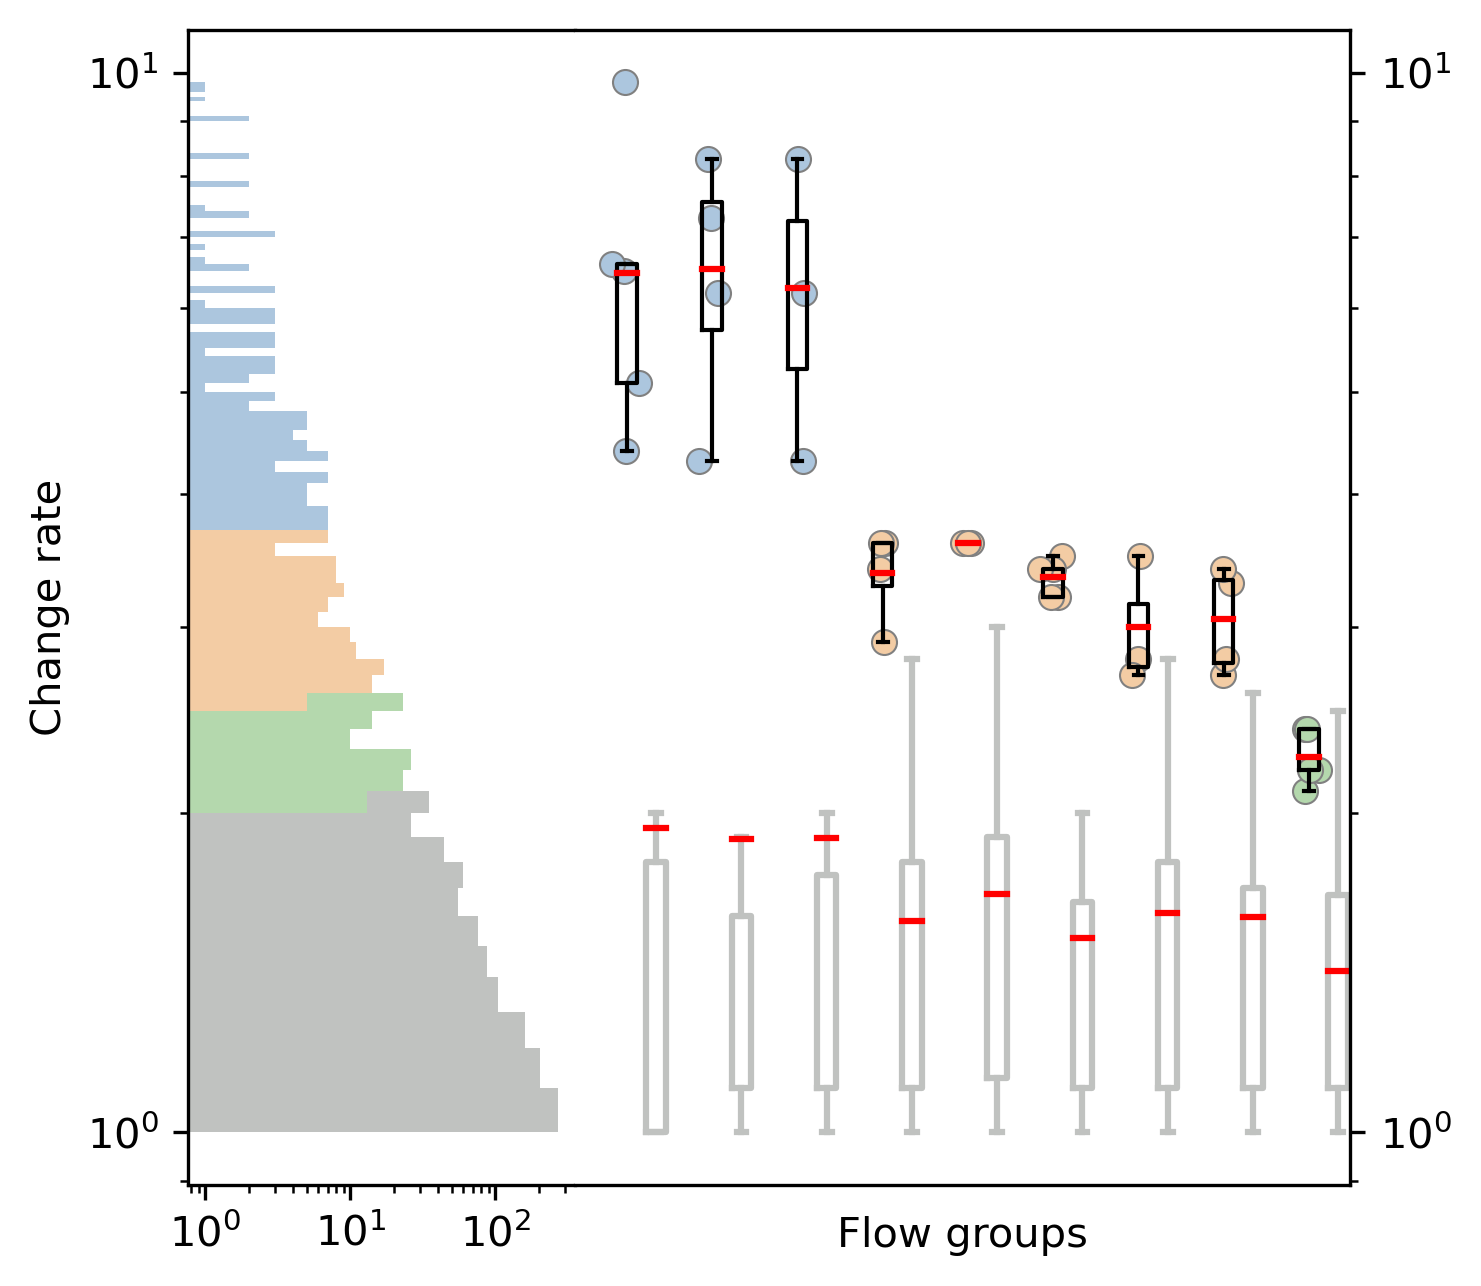

<AxesSubplot: xlabel='Flow groups'>

In [51]:
flow_boxplot_edge_ratio_one_columns(sig_co_in_alpha_rg,
                                    G_t2,G_t1,
                                    selected_high_weights_list,
                                    np.concatenate((external_subgraph_weights, 
                                                      [i[0] for i in selected_low_weights_list[0]], 
                                                      [i[0] for i in selected_low_weights_list[1]], 
                                                      [i[0] for i in selected_low_weights_list[2]])),
                                    three_group_true_edge,
                                    three_group_noise_edge,
                                    88,
                                    'coin_30noise_rg',
                                    show_inter = True,
                                    com_is_list=True,
                                    figure_size=(5,5))

# Global view

In [11]:
co_in_alpha_1=CFEP.generate_dendrogram(G_t2,G_t1,
                                             obj_func='fraction_max',
                                             obj_dir='max', resolution = 1)
# com_dict_max_level0=CFEP.partition_at_level(com_dict_max,0)
print('detection result: ',com_dict2list_for_CFEP_sij(co_in_alpha_1))
print('Ground true partition: ', incre_subgraph)

detection result:  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]]
Ground true partition:  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]]


In [12]:
co_in_alpha_1_ls = com_dict2list_for_CFEP_sij(co_in_alpha_1)
stat_co_in_1, sig_co_in_alpha_1 = stat_table_in_de(G_t2,G_t1, co_in_alpha_1_ls)
stat_co_in_1[(stat_co_in_1['Intra-flow']!=1)&(stat_co_in_1['Pseudo p-value']<0.05)]

,Intra-flow,$R_{int}^{F}$,$R_{ext}^{F}$,Pseudo p-value
0,158,3.897,1.326,0.001
1,151,2.374,1.328,0.001
2,149,1.866,1.315,0.001


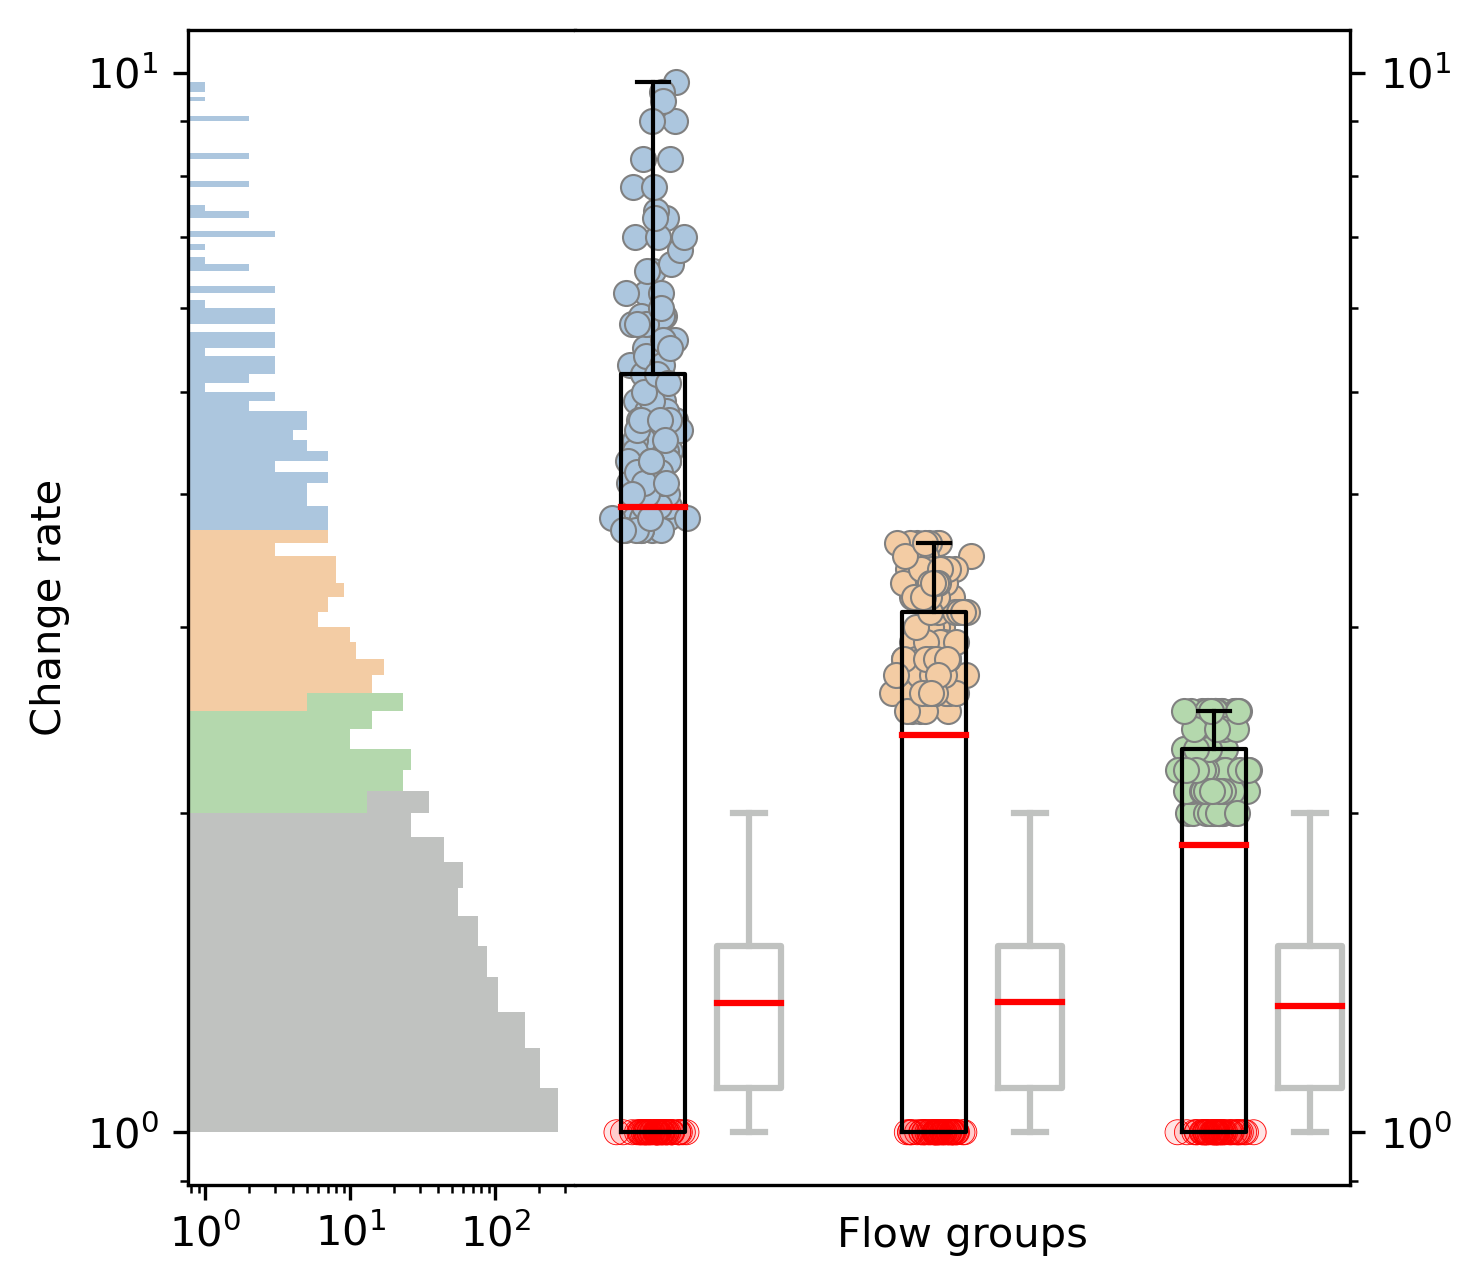

<AxesSubplot: xlabel='Flow groups'>

In [13]:
flow_boxplot_edge_ratio_one_columns(sig_co_in_alpha_1,
                                    G_t2,G_t1,
                                    selected_high_weights_list,
                                    np.concatenate((external_subgraph_weights, 
                                                      [i[0] for i in selected_low_weights_list[0]], 
                                                      [i[0] for i in selected_low_weights_list[1]], 
                                                      [i[0] for i in selected_low_weights_list[2]])),
                                    three_group_true_edge,
                                    three_group_noise_edge,
                                    88,
                                    'coin_30noise_1',
                                    show_inter = True,
                                    com_is_list=True,
                                    figure_size=(5,5))

In [22]:
change_alpha_results = []
for i in tqdm(np.arange(1, r_g, 0.1)):
    co_in_alpha_i=CFEP.generate_dendrogram(G_t2,G_t1,
                                             obj_func='fraction_max',
                                             obj_dir='max', resolution = i, random_state=0)
    co_in_alpha_i_ls = com_dict2list_for_CFEP_sij(co_in_alpha_i)
    stat_co_in, sig_co_in_alpha_i = stat_table_in_de(G_t2,G_t1, co_in_alpha_i_ls)
    change_alpha_results.append(sig_co_in_alpha_i)

100%|███████████████████████████████████████████████████████████████| 8/8 [06:12<00:00, 46.58s/it]


In [23]:
change_alpha_results.append(sig_co_in_alpha_rg)

In [24]:
# open a file, where you ant to store the data
file = open('coin_1_rg_01_append_rg', 'wb')

# dump information to that file
pickle.dump(change_alpha_results, file)

# close the file
file.close()

In [56]:
abs(np.arange(1, r_g, 0.1)-r_g)

array([0.77642105, 0.67642105, 0.57642105, 0.47642105, 0.37642105,
       0.27642105, 0.17642105, 0.07642105])

## Results analysis

In [8]:
file = open('coin_1_rg_01_append_rg', 'rb')

# dump information to that file
change_alpha_results = pickle.load(file)

# close the file
file.close()

In [45]:
# change_alpha_results[0]
precision, recall = Precision_Recall(change_alpha_results[0], coin_true)
precision, recall = Precision_Recall(change_alpha_results[-1], coin_true)

Precision: 0.6965065502183406
Recall: 1.0
Precision: 1.0
Recall: 0.11285266457680251


Precision: 0.6965065502183406
Recall: 1.0
Precision: 0.7247191011235955
Recall: 0.8087774294670846
Precision: 0.724233983286908
Recall: 0.8150470219435737
Precision: 0.7611336032388664
Recall: 0.5893416927899686
Precision: 0.8843537414965986
Recall: 0.40752351097178685
Precision: 0.9797979797979798
Recall: 0.30407523510971785
Precision: 0.9761904761904762
Recall: 0.25705329153605017
Precision: 1.0
Recall: 0.11285266457680251


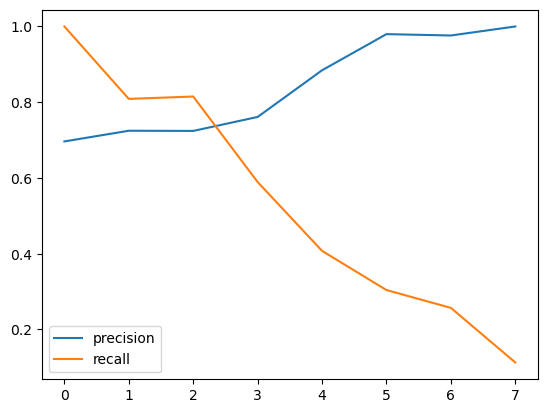

In [53]:
pre = []
rec = []
for i in range(len(change_alpha_results)):
    if i ==len(change_alpha_results)-2:
        continue
    precision, recall = Precision_Recall(change_alpha_results[i], coin_true)
    pre.append(precision)
    rec.append(recall)

plt.plot(range(len(change_alpha_results)-1), pre, label='precision')
plt.plot(range(len(change_alpha_results)-1), rec, label='recall')
plt.legend()
plt.show()
    